# Анализ результатов А/В теста


1. [Введение](#start)
2. [Приоритизация гипотез](#hypothesis)
3. [Анализ A/B-теста](#test)
    * [Анализ кумулятивных метрик](#cumulate)
    * [Анализ выбросов](#abnorm)
    * [Расчет статистической значимости](#stat)
4. [Результат теста](#result)
5. [Общий вывод](#concl)

# Введение <a id="start"></a>

В данной работе мы сначала приоритезируем гипотезы, используя методы ICE и RICE. Далее проведем анализ результатов А/В теста.  
Для анализа результатов мы построим графики кумулятивной выручки, среднего чека и конверсии. Проанализируем относительные изменения групп по этим показателям. Выявим аномалии в данных. Посчитаем статистическую значимость различий конверсии и среднего чека по группам по "сыпым" и "очищенным" данным.  
Сделаем выводы о необходимости дальнейшего продолжения теста и об его успешности.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters

In [2]:
data = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150

# Приоритизация гипотез <a id="hypothesis"></a>

Посмотрим сначала на гипотезы, изучим оцененные параметры.

In [3]:
data

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
data.sort_values(by='Efforts', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Самой большой охват пользователей у восьмой гипотезы, первая гипотеза предположительно больше всего повлияет на охваченных пользователей, вторая гипотеза оценена как самая сложная для проверки. 

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [5]:
data['ICE'] = round(((data['Impact'] * data['Confidence']) / data['Efforts']), 2)
data[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Теперь применим фреймворк RICE и так же отсортируем гипотезы по убыванию приоритета.

In [6]:
data['RICE'] = round(((data['Reach'] * data['Impact'] * data['Confidence']) / data['Efforts']), 2)
data[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [7]:
data[['ICE', 'RICE', 'Hypothesis']].style.highlight_max(color='green')

,ICE,RICE,Hypothesis
0,13.330000,40.000000,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
1,2.000000,4.000000,"Запустить собственную службу доставки, что сократит срок доставки заказов"
2,7.000000,56.000000,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
3,1.120000,9.000000,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"
4,1.000000,3.000000,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"
5,1.330000,4.000000,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"
6,8.000000,40.000000,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"
7,11.200000,112.000000,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
8,16.200000,16.200000,"Запустить акцию, дающую скидку на товар в день рождения"


После применении метода RICE изменился приоритет гипотез по сравнению c ICE. Восьмая гипотеза ("запустить акцию, дающую скидку на товар в день рождения") упала на пятое место, так как у нее самая низкая оценка показателя Reach. А седьмая гипотеза ("добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок") вышла на первое место, так как у нее охват оценен макисмально. Вторая гипотеза ("добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа") вышла на второе место, так как у нее достаточно высокий охват и при этом Effort оценен всего на три балла.
По результатам применения двух методов гипотезы номер 0 ("добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей")  и  7 ("добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок") оказались в тройке лидеров.

# Анализ A/B-теста <a id="test"></a>

Для анализа результатов теста сначала посмотрим на имеющиеся данные. Приведем данные к нужному виду. Проверим на наличие дубликатов и ошибок.

In [8]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Исправим названия столбцов для удобства. Исправим тип данных в столбце с датой заказа.

In [9]:
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [11]:
orders['date'] = orders['date'].astype('datetime64')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Проверим идентификаторы пользователей, посмотрим не попали ли одни и те же пользователи в обе группы.

In [12]:
visitors_a = orders.query('group=="A"')['visitor_id']

In [13]:
double_visitors = orders.query('group=="B" and (visitor_id in @visitors_a)')
double_visitors['visitor_id'].nunique()

58

Нашлось 58 пользователей, которые попали в обе группы. Узнаем какую часть от всех пользователей они составляют.

In [14]:
(58/orders['visitor_id'].nunique())*100

5.625606207565471

В результате анализа мы увидели, что 58 посетителей попали в обе группы. Это около 6% от всех посетителей. Можно было бы убрать этих пользователей из анализа результатов, но эти пользователи так же уже, вероятно, учтены в данных по количеству посетителей на каждый день. Убрать оттуда мы их не сможем. Поэтому оставим их и в таблице с заказами.

Теперь посмотрим на таблицу с заказами. 

In [15]:
orders.duplicated().sum()

0

In [16]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [17]:
visitors['date'] = visitors['date'].astype('datetime64')
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [18]:
visitors.duplicated().sum()

0

В результате изучения данных обнаружена одна проблема с повторяющимися идентификаторами посетителей в разных группах. На данный момент эту ошибку корректно мы исправить не можем, так как эти посетители учтены и в другой таблице.
В остальном, данные без пропуской и дубликатов. Даты в таблицах приведены к нужному типу.

## Анализ кумулятивных метрик <a id="cumulate"></a>

Построим график кумулятивной выручки по группам. Для этого сначала соберем данные уникальных пар значений дат и групп теста. Соберем кумулятивные данные по заказам и визитам, объеденим их в одну таблицу и переименуем колонки в понятные названия.

In [19]:
group_by_date = orders[['date','group']].drop_duplicates()

#куммулятивные данные по заказам
orders_grouped = group_by_date.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date':'max', 'group':'max', 'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}), axis=1).sort_values(
    by=['date','group'])

#куммулятивные данные по визитам
visitors_grouped = group_by_date.apply(lambda x: visitors[np.logical_and(
    visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
    'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

#объединение данных в одной таблице
cumulative_data = orders_grouped.merge(
    visitors_grouped, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


Теперь соберем два датафрейма с кумулятивным количеством заказов и выручкой по дням в каждой группе. И построим график для каждой группы.

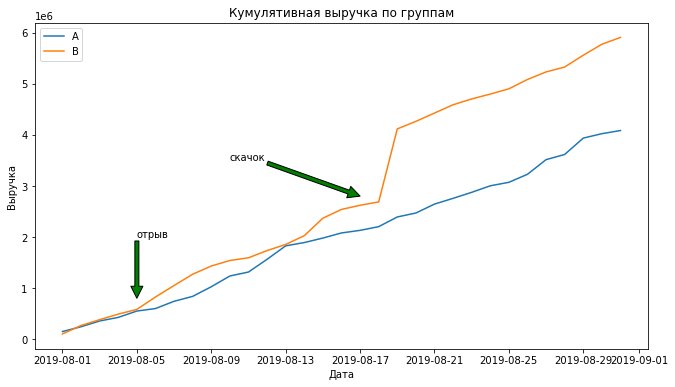

In [20]:
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]
register_matplotlib_converters()
plt.figure(figsize=(11,6))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')
plt.legend()
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g'))
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

У группы А выручка почти равномерно увеличиватеся в течение всего теста. Но у группы В есть видно резкое увеличение выручки после 17 августа - возможно был какой-то очень дорогой заказ, либо резко увеличилось число заказов.

Теперь построим графики кумулятивного среднего чека по группам. Для этого резделим кумулятивную выручку на кумулятивное количество заказов.

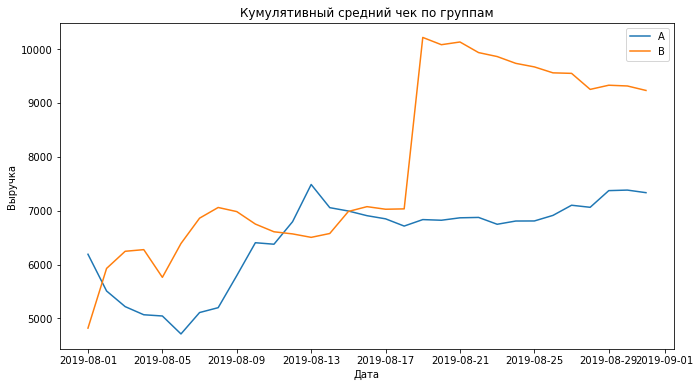

In [21]:
plt.figure(figsize=(11,6))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')
plt.legend()
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

Средний чек группы становится более равномерным уже во второй половине месяца. Средний чек группы вырос почти в два раза после 17 августа и далее начал незначительно снижаться. Необходимо проверить заказы в этой группе на аномалии.

Построим график относитльного изменения кумулятивного среднего чека группы В к группе А. Сначала соберем данные по двум группам в один датафрейм, после построим отношение средних чеков. Добавим ось Х на график для наглядного отображения.

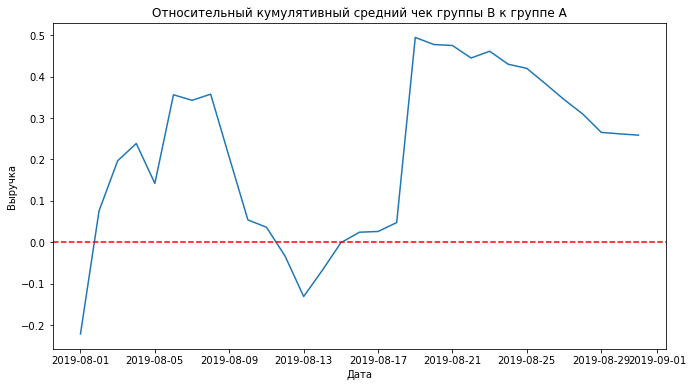

In [22]:
cumulative_revenue_merged = cumulative_revenue_A.merge(
    cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(11,6))
plt.plot(cumulative_revenue_merged['date'], (
    cumulative_revenue_merged['revenueB']/cumulative_revenue_merged['ordersB'])/(
    cumulative_revenue_merged['revenueA']/cumulative_revenue_merged['ordersA'])-1)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Относительный кумулятивный средний чек группы B к группе А')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

Опять же видим, что после 17 августа средний чек группы В резко увеличился относительно среднего чека группы А, хотя до этого момента было значительное падение. 

Проанализируем график кумулятивной конверсии по группам.

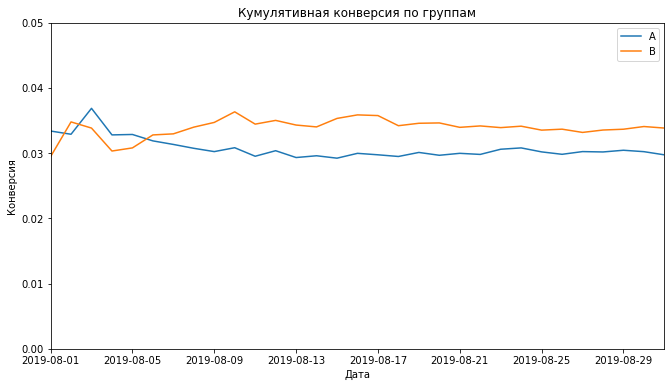

In [23]:
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']
plt.figure(figsize=(11,6))
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
plt.legend()
plt.axis(["2019-08-01", '2019-08-31', 0, 0.05])
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

В самом начале заметны колебания конверсии, но уже после пятого числа конверсия группы превысила группа А, и далее конверсии по двум группам стабилизоровались.  
Посмотрим на график относительного изменения кумулятивной конверсии группы В к группе А.

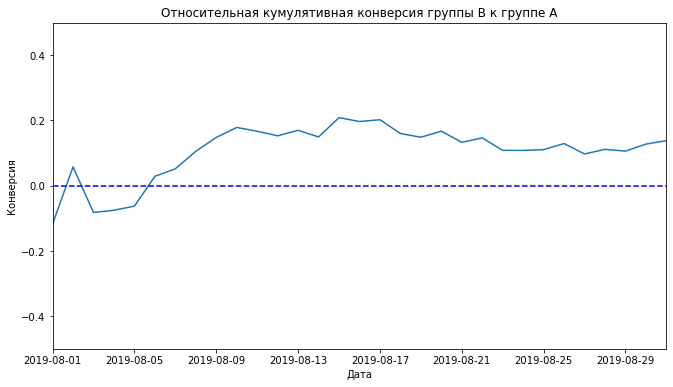

In [24]:
cumulative_conversions_merged = cumulative_data_A[
    ['date','conversion']].merge(cumulative_data_B[
    ['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(11,6))
plt.plot(cumulative_conversions_merged['date'], 
         cumulative_conversions_merged['conversionB']/cumulative_conversions_merged['conversionA']-1)
plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.5])
plt.title('Относительная кумулятивная конверсия группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.axhline(y=0, color='blue', linestyle='--')
plt.show()

Первые несколько дней теста конверсия группы А была выше группы В. Но после пятого числа группа В по конверсии вышла вперед и во второй половине месяца отношений конверский стабилизировалось.

Мы проанализировали данные по всем имеющимся заказам. У группы В лучшие показатели и по конверсии и по выручке. Но при этом, если по конверсии группы к концу мемяца стабилизировались, по выручке и средним чекам такого нельзя сказать из-за резкого роста во второй половине месяца.  
Далее проанализируем данные на аномалии.

## Анализ выбросов <a id="abnorm"></a>

Построим точечный график количества заказов по пользователям.

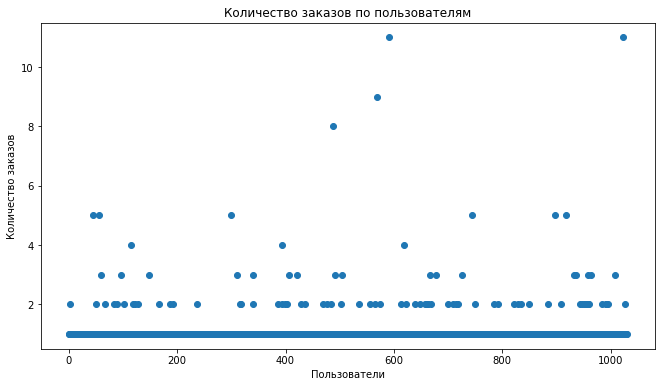

In [25]:
transactions = orders.groupby('visitor_id').agg({'transaction_id': 'count'}).reset_index()
transactions.columns = ['visitors', 'transactions']
x_values = pd.Series(range(0,len(transactions)))
plt.figure(figsize=(11,6))
plt.scatter(x_values, transactions['transactions'])
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

На графике видно, что много пользователей с 2-5 закзами.
Посчитаем 95-й и 99-й перецентили количество заказов и выберем границу для определения аномальных пользователей.

In [26]:
print(np.percentile(transactions['transactions'], [95, 99])) 

[2. 4.]


Менее 5% пользователей с заказами больше двух, и менее 1% с количеством заказов больше четырех.
Будем считать аномальным количество заказов больше трех.

Теперь построим точечный график стоимости заказов, вычеслим аномалии для их дальнейшего исключения.

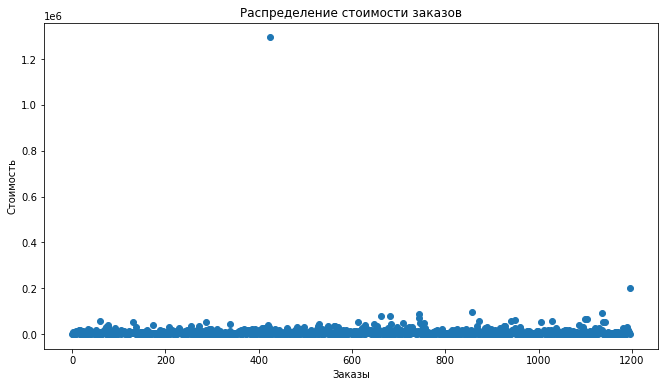

In [27]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(11,6))
plt.scatter(x_values, orders['revenue']) 
plt.title('Распределение стоимости заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость')
plt.show()

Из-за совсем аномального заказа стоимостью более миллиона, шкала по оси у растянулась и сложно судить об остальных заказах. Посмтроим еще один график, указав границы оси у.

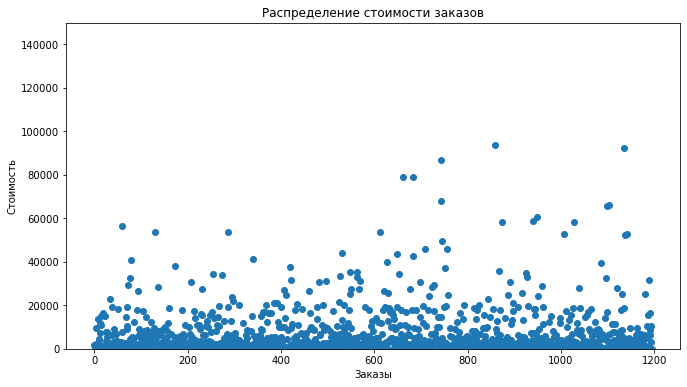

In [28]:
plt.figure(figsize=(11,6))
plt.scatter(x_values, orders['revenue']) 
plt.title('Распределение стоимости заказов')
plt.ylim(0, 150000)
plt.xlabel('Заказы')
plt.ylabel('Стоимость')
plt.show()

Теперь графике уже видно, что большая часть заказов до 20000. Посчитаем 95-й и 99-й перецентили.

In [29]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Менее 5% заказов стоимостью выше 28000, и менее 1% заказов дороже 58300. Будем считать аномальными заказы дороже 30000.

## Расчет статистической значимости <a id="stat"></a>

Теперь, когда мы нашли аномалии в данных, посчитаем статистичечкую значимость рзличий в конверсии и средем чеке между группами сначала по "сырым" данным,а после - по "очищенным".  
Создадим таблицу, сгруппированную по дате, где будут данные по количеству посещений, заказов и сумме выручки по каждой группе на определенную дату и кумулятивные данные по этим же показателям.

In [30]:
#количество посещений на дату в группе А
visitors_daily_A = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_A.columns = ['date', 'visitors_per_date_A']

#кумулятивное количество посещений на дату в группе А
visitors_cummulative_A = visitors_daily_A.apply(
    lambda x: visitors_daily_A[visitors_daily_A['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}), axis=1)
visitors_cummulative_A.columns = ['date', 'visitors_cummulative_A']

#количество посещений на дату в группе В
visitors_daily_B = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_B.columns = ['date', 'visitors_per_date_B']

#кумулятивное количество посещений на дату в группе В
visitors_cummulative_B = visitors_daily_B.apply(
    lambda x: visitors_daily_B[visitors_daily_B['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}), axis=1)
visitors_cummulative_B.columns = ['date', 'visitors_cummulative_B']

#данные по количеству заказов и выручке в группе А
orders_daily_A = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'count', 'revenue': 'sum'}))
orders_daily_A.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

#кумулятивные данные по количеству заказов и выручке в группе А
orders_cummulative_A = orders_daily_A.apply(
    lambda x: orders_daily_A[orders_daily_A['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ), axis=1).sort_values(by=['date'])
orders_cummulative_A.columns = ['date', 'orders_cummulative_A','revenue_cummulative_A']

#данные по количеству заказов и выручке в группе В
orders_daily_B = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'count', 'revenue': 'sum'})
)
orders_daily_B.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

#кумулятивные данные по количеству заказов и выручке в группе В
orders_cummulative_B = orders_daily_B.apply(
    lambda x: orders_daily_B[orders_daily_B['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ), axis=1).sort_values(by=['date'])
orders_cummulative_B.columns = ['date', 'orders_cummulative_B', 'revenue_cummulative_B']

#объединение всех данных в одну таблицу
raw_data = (
    orders_daily_A.merge(orders_daily_B, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_A, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_B, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_A, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_B, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_A, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_B, left_on='date', right_on='date', how='left'))

raw_data.head()

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Создадим таблицы с количеством заказов на каждого пользователя по группам.

In [31]:
orders_by_users_A = (
    orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg(
        {'transaction_id':'count'}))
orders_by_users_A.columns = ['visitor_id', 'orders']

orders_by_users_B = (
    orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg(
        {'transaction_id': 'count'}))
orders_by_users_B.columns = ['visitor_id', 'orders'] 

Сформулируем нулевую и альтернативную гипотезы.  
<b>H<sub>0</sub>:</b> Средняя конверсия группы А равна конверсии группы В.  
<b>H<sub>1</sub>:</b> Средняя конверсия группы А отличается от конверсии группы В.

Объявим переменные, в которых пользователям из каждой группы будет соответствовать количество заказов. Расчитаем колиство пользователей, которые ничего не заказали и простиавим им нули.

In [32]:
sample_A = pd.concat([orders_by_users_A['orders'], pd.Series(
    0, index=np.arange(raw_data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ), name='orders')], axis=0)
sample_B = pd.concat([orders_by_users_B['orders'], pd.Series(
    0, index=np.arange(raw_data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ), name='orders')], axis=0)

In [33]:
print("{0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B, alternative='two-sided')[1]))#расчет p-value
print("{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))#рачет отношения средних чеков групп

0.017
0.138


Результам p-value получился меньше уровня значимости 0.05, значит отвергаем нулевую гипотезу, по "сырым" данным конверсия группы А и группы В отличается.  
Средняя конверсия группы В выше средней конверсии группы А почти на 14%.

Посчитаем так же по сырым данным статистическую значимость различий в среднем чеке.  
Сформулируем гипотезы:  
<b>H<sub>0</sub>:</b> Средний чек группы А равен среднему чеку группы В.  
<b>H<sub>1</sub>:</b> Средний чек группы А отличается от среднего чека группы В.

In [34]:
#расчет p-value
print('{0:.3f}'.format(stats.mannwhitneyu(
    orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], 
    alternative='two-sided')[1]))
#расчет отношения средних чеков
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()
                       /orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


P-value получился значительно больше 0.05. Нет причин отвергать нулевую гипотезу и считать, что средний чек по группам отличается.  
Однако в соотношении срений чек группы В на 26% выше среднего чека группы А.

Теперь расчитаем статистическую значимость различий в конверсии и среднем чеке по "очищенным" данным. Мы приняли за аномалии заказы от трех штук и по сумме выше 30 000.  
Сделаем срез по таким заказам и объединим таких пользователей в одну группу. Посмотрим сколько их всего.

In [35]:
many_orders = pd.concat([orders_by_users_A[orders_by_users_A['orders'] > 3]['visitor_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 3]['visitor_id']], axis=0)

expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']

abnormal_users = pd.concat([many_orders, expensive_orders], axis=0).drop_duplicates().sort_values()

print(abnormal_users.shape) 

(57,)


Всего таких пользователей 57 человек.  
Посмотрим, как эти пользователи повлияли на результаты теста. Подготовим выборки количества заказов по пользователям по группам теста и посчитаем статистическую значимость различий в конверсии между группами.  
Сформулируем гипотезы.  
<b>H<sub>0</sub>:</b> Средняя конверсия группы А равна конверсии группы В.  
<b>H<sub>1</sub>:</b> Средняя конверсия группы А отличается от конверсии группы В.

In [36]:
filtered_sample_A = pd.concat(
    [orders_by_users_A[np.logical_not(orders_by_users_A['visitor_id'].isin(
        abnormal_users))]['orders'],pd.Series(
        0, index=np.arange(raw_data['visitors_per_date_A'].sum() - len(
            orders_by_users_A['orders'])), name='orders')], axis=0)

filtered_sample_B = pd.concat([orders_by_users_B[np.logical_not(
    orders_by_users_B['visitor_id'].isin(abnormal_users))]['orders'],
    pd.Series(0, index=np.arange(raw_data['visitors_per_date_B'].sum() - len(
        orders_by_users_B['orders'])), name='orders')], axis=0)

print('{0:.3f}'.format(stats.mannwhitneyu(filtered_sample_A, filtered_sample_B, 
                                          alternative='two-sided')[1]))
print('{0:.3f}'.format(filtered_sample_B.mean()/filtered_sample_A.mean()-1)) 

0.018
0.148


Результаты практически не изменились.  
Посмотрим на различия в среднем чеке.  
<b>H<sub>0</sub>:</b> Средний чек группы А равен среднему чеку группы В.  
<b>H<sub>1</sub>:</b> Средний чек группы А отличается от среднего чека группы В.

In [37]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(orders['group'] == 'A',
                          np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'], 
    alternative='two-sided')[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group'] == 'B', 
                          np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',np.logical_not(
            orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean() - 1)) 

0.958
-0.020


По-прежнему, нет причин считать, что средние чеки по группам отличаются, p-value увеличился. Но при этом, по относильному показателю видно, как сильно изменился средний чек группы В после удаления анамальных заказов и, хоть и не значительно, но проиграл среднему чеку группы А.

# Результат теста <a id="result"></a>

Анализ результатов теста показал следующее:
 - Между группам наблюдается статистически значимое отличие по конверсии, как по "сырым" данным, так и по отфильтрованным.
 - При этом по среднему чеку между группами нет статистически значимого отличия, ни по "сырым", ни по очещенным данным.
 - Кумулятивная конверсия группы В почти на 20% лучше группы А и это приемущество стабилизировалось.
 - График различий по среднему чеку показывает резкий провал и подъем в середине месяца группы В относительно группы А, но по большей части графика все же у группы В преимущество.
 
По имеющимся данным тест можно остановить и признать успешным.

# Общий вывод <a id="concl"></a>

В текущей работе мы приоритизировали гипотезы и провели анализ А/В-теста.  
Для начала мы зугрузили необходимые данные. Ознакомились с гипотезами и приоритизировали их двумя методами - ICE и RICE. По результату выделили наиболее приоритетные гипотезы.  
Далее ознакомились с данными по результатам А/В-теста. Выявили, что в данных по посетителям есть 58 человек, которые попали в обе группы.  
Далее мы изучили кумулятивные метрики по группам и их относительное изменение. Так, графики показали, что кумулятиваная выручка группы В практически сразу превысила выручку группы А. На графике кумулятивного среднего чека увидели, что во второй половине месяца средний чек группы резко вырос относительно среднего чека группы А, хотя до этого показывал падение. График изменения кумулятивной конверсии показал, что конверсия группы В выше конверсии группы А почти с самого начала теста.  
После этого мы изучили выбросы в данных по заказам и определили границы для их определения. Посчитали статистическую значимость различий конверсии и среднего чека между группами по "сырым" данным и очищенным от выбросов. Результаты показали, что конверсия группы В лучше конверсии группы А в обоих случаях. При это средние чеки групп не показали статистически значимых отличий так же ни по "сырым" данным, ни по отфильтрованным. Однако после удаления выбросов, мы увидели, что в соотношении средних чеков двух групп отличий действительно нет.  
По итогу анализа мы приняли решение остановить тест и признать его успешным. Конверсия группы В значильно выше группы А, а средний чек хоть и не увиличился, но и не изменился в меньшую сторону.
